### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

2023-02-06 18:25:22,949	INFO worker.py:1528 -- Started a local Ray instance.


#### Train the network

In [2]:
n = 10
popsize = 20
name = 'centered2'
#device = torch.device('mps:0')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, popsize=popsize)

[2023-02-06 18:25:24] INFO     <35770> evotorch.core: Instance of `Custom_NEProblem` (id:4567365712) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-06 18:25:24] INFO     <35770> evotorch.core: Instance of `Custom_NEProblem` (id:4567365712) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-06 18:25:24] INFO     <35770> evotorch.core: Instance of `Custom_NEProblem` (id:4567365712) -- The `device` of the problem is set as cpu
[2023-02-06 18:25:24] INFO     <35770> evotorch.core: Instance of `Custom_NEProblem` (id:4567365712) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-06 18:25:24] INFO     <35770> evotorch.core: Instance of `Custom_NEProblem` (id:4567365712) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [3]:
trainer.train(500, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.0969)
pop_best_eval : -9.903548240661621
  median_eval : -1261.622314453125
    mean_eval : -1094.5867919921875
    best_eval : -9.903548240661621
   worst_eval : -1917.22802734375

         iter : 2
     stepsize : ReadOnlyTensor(0.0941)
pop_best_eval : -8.798128128051758
  median_eval : -952.0400390625
    mean_eval : -819.791015625
    best_eval : -8.798128128051758
   worst_eval : -1917.22802734375

         iter : 3
     stepsize : ReadOnlyTensor(0.0919)
pop_best_eval : 20.438570022583008
  median_eval : -900.0551147460938
    mean_eval : -951.2013549804688
    best_eval : 20.438570022583008
   worst_eval : -2156.43505859375

         iter : 4
     stepsize : ReadOnlyTensor(0.0900)
pop_best_eval : -171.27438354492188
  median_eval : -1070.28466796875
    mean_eval : -1081.6236572265625
    best_eval : 20.438570022583008
   worst_eval : -2156.43505859375

         iter : 5
     stepsize : ReadOnlyTensor(0.0885)
pop_best_eval : -27.

In [4]:
network = trainer.get_trained_network()

#### Visualize trained network

In [5]:
organism = generate_organism(10, device)
graph = organism.toGraph()
visualizer = Visualizer()

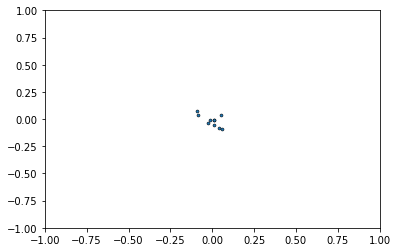

In [6]:
anim = visualizer.animate_organism(graph, network, frames=100)
IPython.display.HTML(anim.to_jshtml())

In [7]:
#anim.save('../animation/centered2.gif', writer='imagemagick', fps=10)
visualizer.save_animation_to_gif(anim, name, 10)

In [8]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>